In [2]:
pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 42.8 MB/s eta 0:00:00


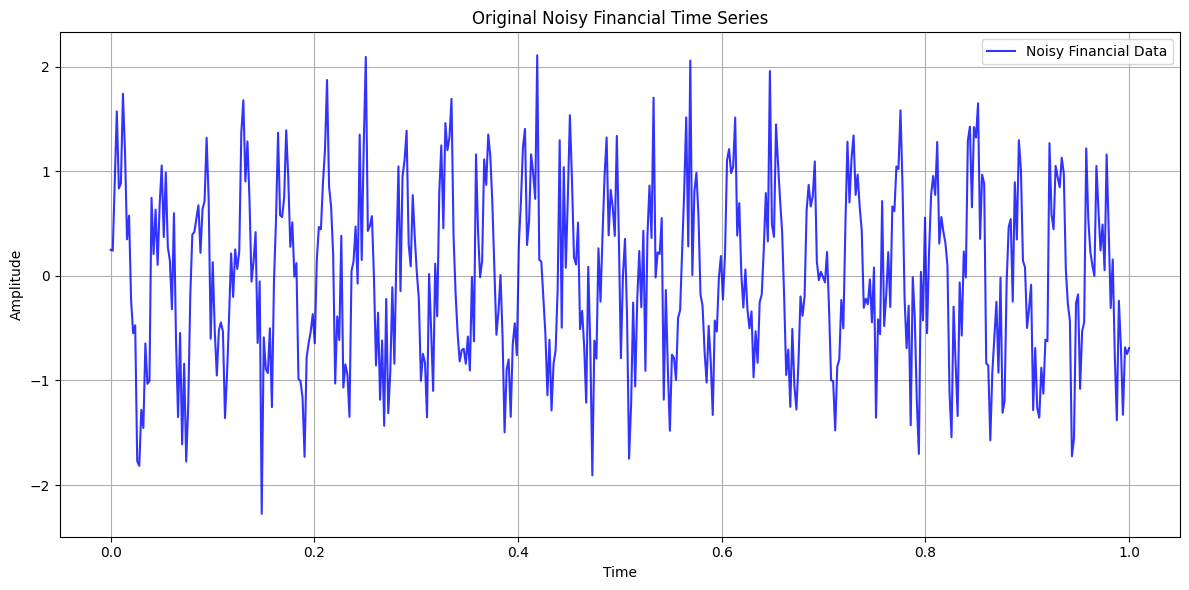

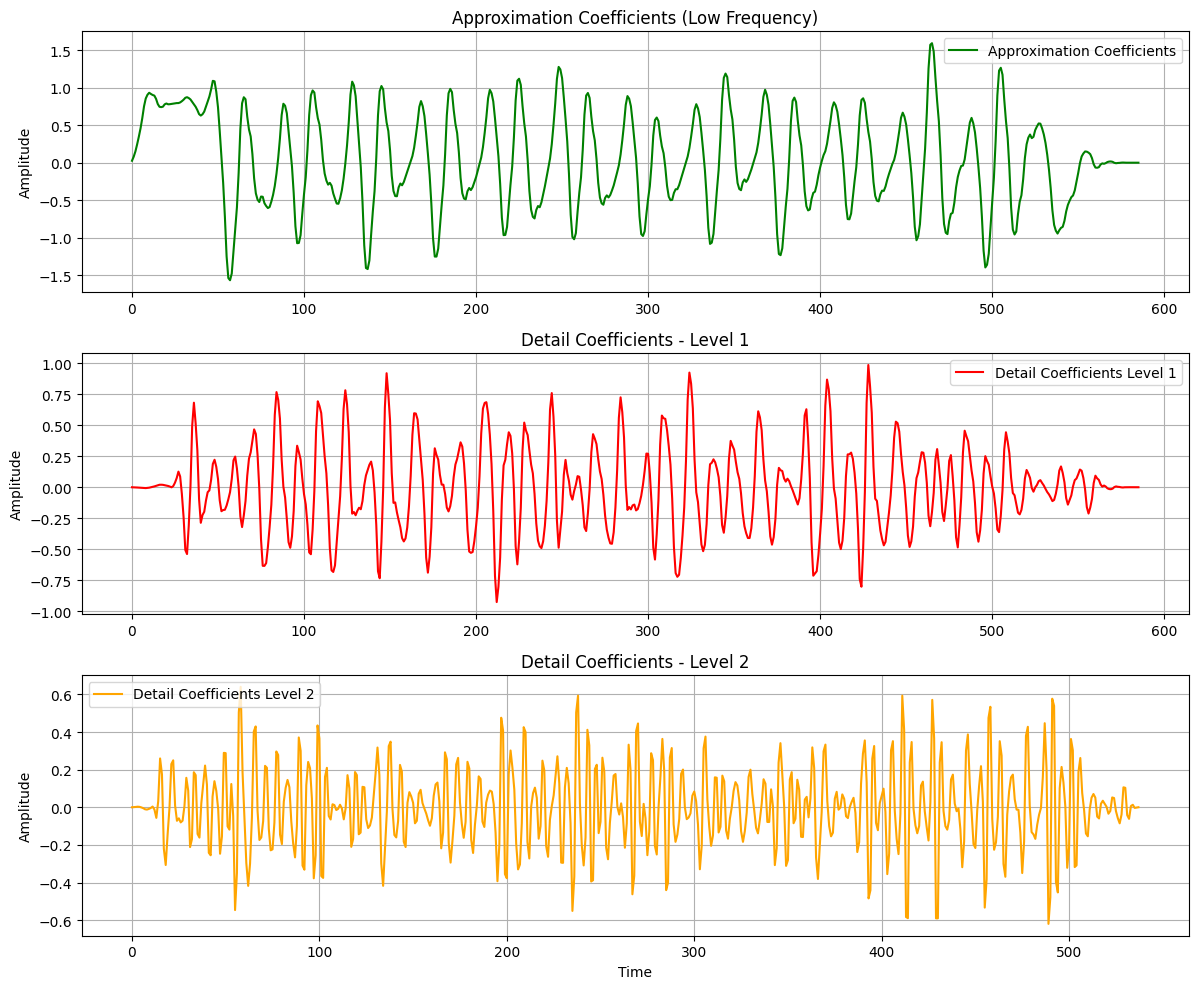

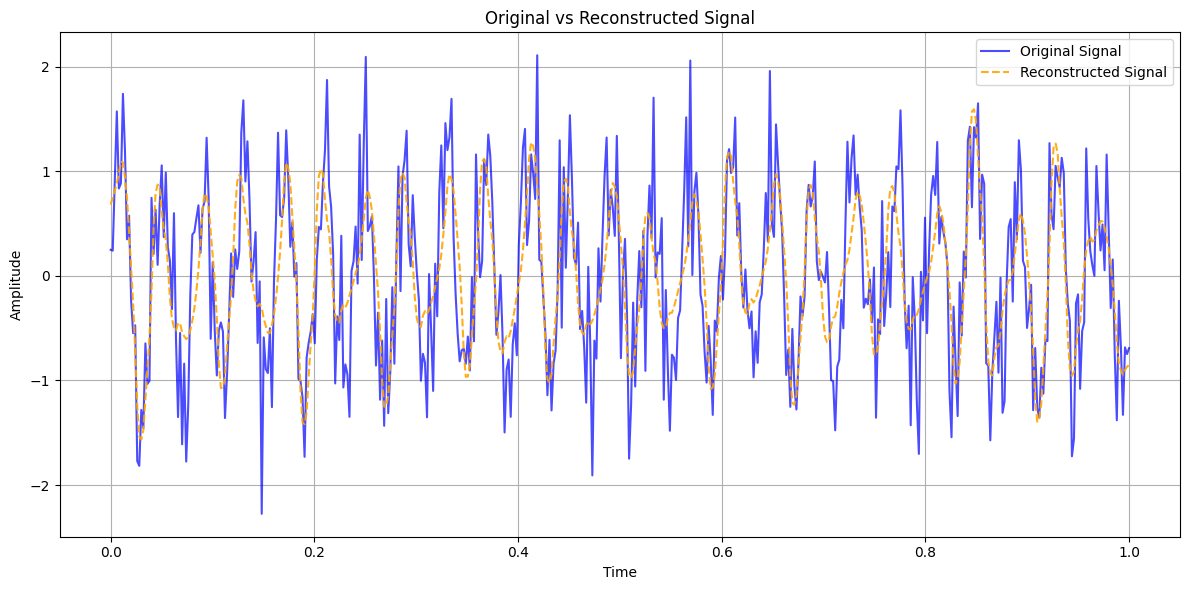

Original Signal Plot saved to: original_signal.png
Decomposition Coefficients Plot saved to: decomposition_coefficients.png
Reconstructed Signal Plot saved to: reconstructed_signal.png


In [5]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Simulate financial time series
np.random.seed(42)
time = np.linspace(0, 1, 500)
financial_data = np.sin(50 * np.pi * time) + np.random.normal(0, 0.5, len(time))

# Step 2: Plot the original noisy signal
plt.figure(figsize=(12, 6))
plt.plot(time, financial_data, label='Noisy Financial Data', color='blue', alpha=0.8)
plt.title('Original Noisy Financial Time Series')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
original_signal_path = "original_signal.png"
plt.savefig(original_signal_path)
plt.show()

# Step 3: Perform wavelet decomposition
wavelet = 'db4'  # Daubechies wavelet
coeffs = pywt.wavedec(financial_data, wavelet, level=3)

# Step 4: Visualize wavelet decomposition (coefficients)
plt.figure(figsize=(12, 10))

# Approximation coefficients
plt.subplot(3, 1, 1)
plt.plot(pywt.upcoef('a', coeffs[0], wavelet, level=3), color='green', label='Approximation Coefficients')
plt.title('Approximation Coefficients (Low Frequency)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.plot(pywt.upcoef('d', coeffs[1], wavelet, level=3), color='red', label='Detail Coefficients Level 1')
plt.title('Detail Coefficients - Level 1')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Detail coefficients (Level 2)
plt.subplot(3, 1, 3)
plt.plot(pywt.upcoef('d', coeffs[2], wavelet, level=2), color='orange', label='Detail Coefficients Level 2')
plt.title('Detail Coefficients - Level 2')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
decomposition_path = "decomposition_coefficients.png"
plt.savefig(decomposition_path)
plt.show()

# Step 5: Reconstruct the signal using approximation coefficients
reconstructed_signal = pywt.waverec(coeffs[:1] + [None] * (len(coeffs) - 1), wavelet)

# Adjust lengths for visualization
min_length = min(len(time), len(reconstructed_signal))
adjusted_time = time[:min_length]
adjusted_original_signal = financial_data[:min_length]
adjusted_reconstructed_signal = reconstructed_signal[:min_length]

# Step 6: Plot original vs reconstructed signal
plt.figure(figsize=(12, 6))
plt.plot(adjusted_time, adjusted_original_signal, label='Original Signal', alpha=0.7, color='blue')
plt.plot(adjusted_time, adjusted_reconstructed_signal, label='Reconstructed Signal', linestyle='--', alpha=0.9, color='orange')
plt.title('Original vs Reconstructed Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
reconstructed_signal_path = "reconstructed_signal.png"
plt.savefig(reconstructed_signal_path)
plt.show()

# Print file paths for saved plots
print(f"Original Signal Plot saved to: {original_signal_path}")
print(f"Decomposition Coefficients Plot saved to: {decomposition_path}")
print(f"Reconstructed Signal Plot saved to: {reconstructed_signal_path}")

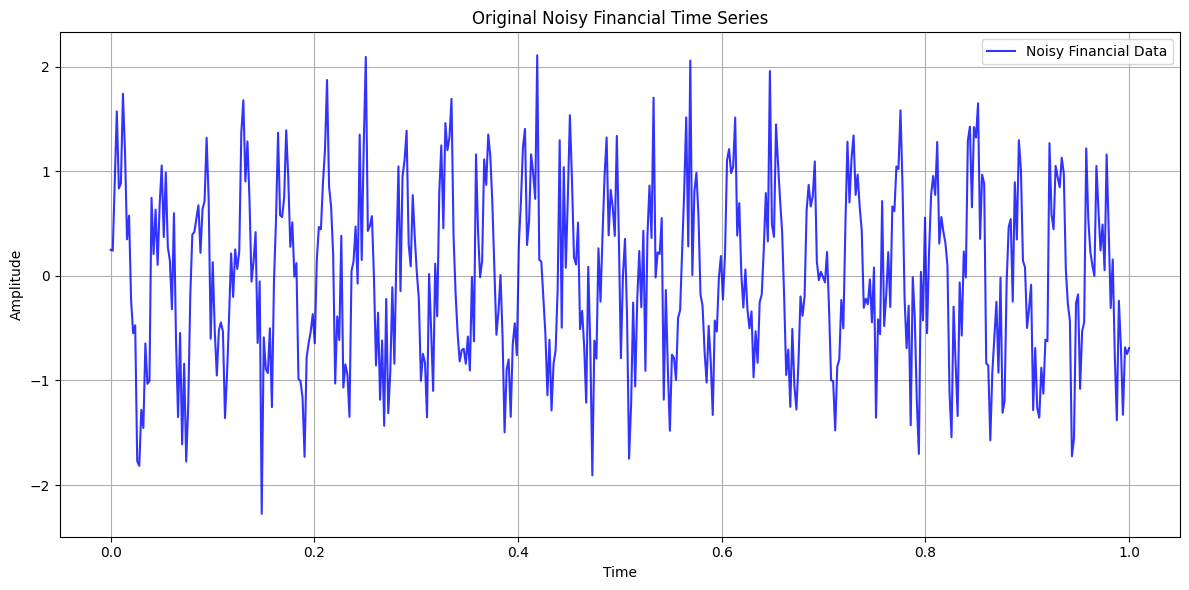

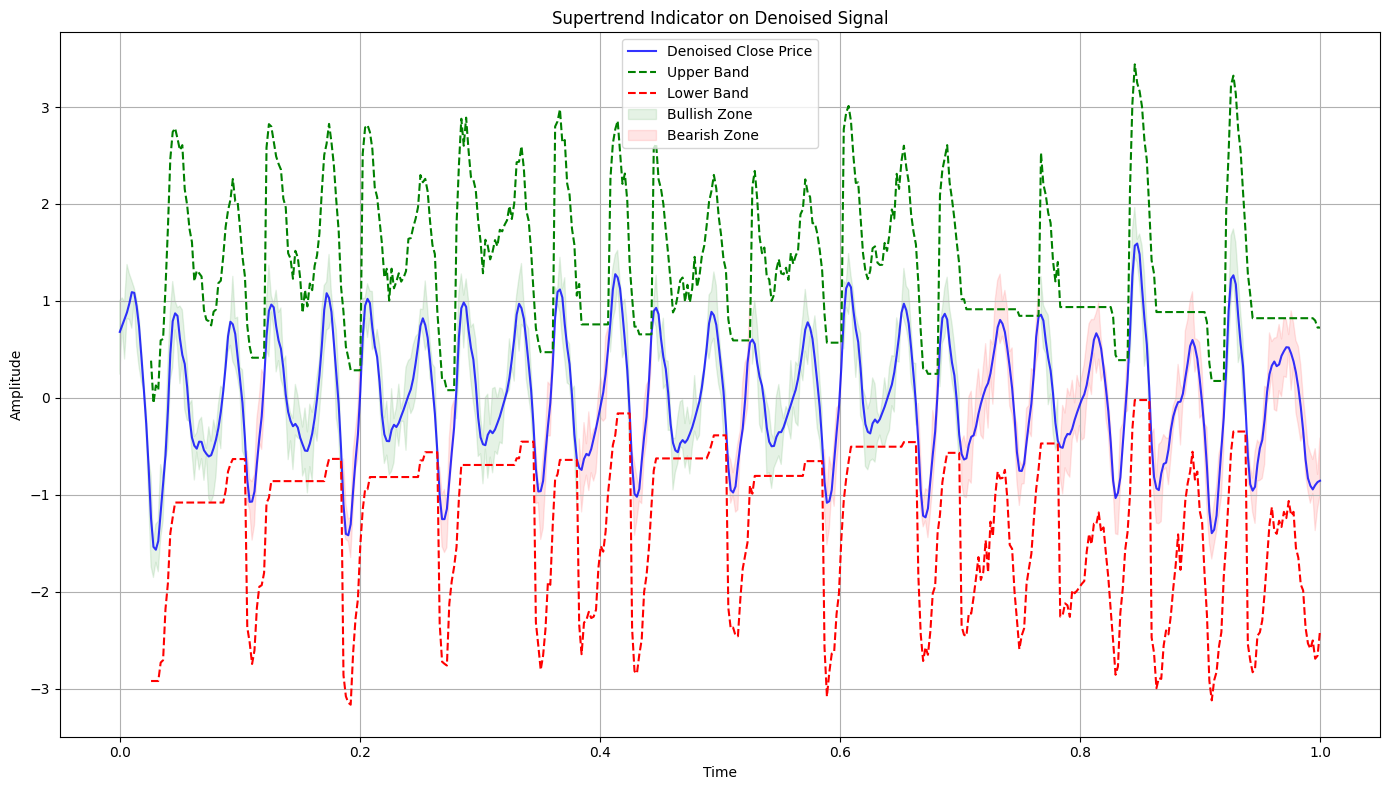

In [8]:
import pywt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Simulate financial time series
np.random.seed(42)
time = np.linspace(0, 1, 500)
financial_data = np.sin(50 * np.pi * time) + np.random.normal(0, 0.5, len(time))

# Plot the original noisy signal
plt.figure(figsize=(12, 6))
plt.plot(time, financial_data, label='Noisy Financial Data', color='blue', alpha=0.8)
plt.title('Original Noisy Financial Time Series')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 2: Perform wavelet decomposition
wavelet = 'db4'  # Daubechies wavelet
coeffs = pywt.wavedec(financial_data, wavelet, level=3)

# Reconstruct the signal using approximation coefficients (denoised signal)
denoised_signal = pywt.waverec(coeffs[:1] + [None] * (len(coeffs) - 1), wavelet)

# Convert denoised signal to Pandas Series
denoised_signal_series = pd.Series(denoised_signal[:len(time)])

# Generate high, low, and close data for the denoised signal
denoised_high = denoised_signal_series + 0.5 * np.random.rand(len(denoised_signal_series))
denoised_low = denoised_signal_series - 0.5 * np.random.rand(len(denoised_signal_series))
denoised_close = denoised_signal_series

# Step 3: Supertrend Calculation
def true_range(high, low, close):
    return pd.DataFrame({
        'H-L': high - low,
        'H-PC': abs(high - close.shift(1)),
        'L-PC': abs(low - close.shift(1))
    }).max(axis=1)

def average_true_range(high, low, close, period=14):
    tr = true_range(high, low, close)
    return tr.rolling(window=period).mean()

def supertrend(high, low, close, atr_multiplier=3, period=14):
    atr = average_true_range(high, low, close, period)
    hl2 = (high + low) / 2  # Median price
    upper_band = hl2 + (atr_multiplier * atr)
    lower_band = hl2 - (atr_multiplier * atr)

    # Initialize supertrend
    supertrend = [True] * len(close)  # True = Bullish, False = Bearish

    for i in range(1, len(close)):
        if close[i] > upper_band[i - 1]:
            supertrend[i] = True
        elif close[i] < lower_band[i - 1]:
            supertrend[i] = False
        else:
            supertrend[i] = supertrend[i - 1]

            # Adjust bands
            if supertrend[i]:
                lower_band[i] = max(lower_band[i], lower_band[i - 1])
            else:
                upper_band[i] = min(upper_band[i], upper_band[i - 1])

    return pd.DataFrame({'Supertrend': supertrend, 'Upper Band': upper_band, 'Lower Band': lower_band})

# Calculate Supertrend on denoised signal
supertrend_data_denoised = supertrend(pd.Series(denoised_high), pd.Series(denoised_low), pd.Series(denoised_close))

# Step 4: Visualize Supertrend on Denoised Signal
adjusted_time = time[:len(denoised_signal_series)]
adjusted_denoised_high = np.nan_to_num(np.array(denoised_high[:len(adjusted_time)]))
adjusted_denoised_low = np.nan_to_num(np.array(denoised_low[:len(adjusted_time)]))
adjusted_denoised_close = np.nan_to_num(np.array(denoised_close[:len(adjusted_time)]))
bullish_mask = np.nan_to_num(supertrend_data_denoised['Supertrend'].iloc[:len(adjusted_time)].values)

plt.figure(figsize=(14, 8))
plt.plot(adjusted_time, adjusted_denoised_close, label='Denoised Close Price', color='blue', alpha=0.8)
plt.plot(adjusted_time, supertrend_data_denoised['Upper Band'].iloc[:len(adjusted_time)], label='Upper Band', color='green', linestyle='--')
plt.plot(adjusted_time, supertrend_data_denoised['Lower Band'].iloc[:len(adjusted_time)], label='Lower Band', color='red', linestyle='--')

# Highlight Bullish and Bearish Regions
plt.fill_between(adjusted_time, adjusted_denoised_low, adjusted_denoised_high, where=bullish_mask.astype(bool), color='green', alpha=0.1, label='Bullish Zone')
plt.fill_between(adjusted_time, adjusted_denoised_low, adjusted_denoised_high, where=~bullish_mask.astype(bool), color='red', alpha=0.1, label='Bearish Zone')

plt.title('Supertrend Indicator on Denoised Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()